## [DO NOT EDIT] Header

本笔记本实现了用于数字分类的逻辑回归模型，包含超参数调优。
所有代码必须遵循实现指南中定义的项目结构和命名约定。

In [69]:
# Import required libraries
import sys
import os
import json
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import isclose, sqrt
from IPython.display import display
from collections import defaultdict

# Enable inline plotting in Jupyter notebooks
%matplotlib inline

# 路径设置 - 导入此模块会自动设置Python路径
import path_setup

# 直接导入项目模块（IDE可以正确追踪）
from load_data import load_mnist_dataset
from evaluate import eval_classification, eval_classification_with_roc
from visualize import (
    plot_confusion_matrix, 
    plot_confusion_matrix_detailed,
    plot_bar,
    plot_validation_curves
)

# Constants
RANDOM_STATE = 42
NOTEBOOK_BASENAME = "part1_logistic_regression"

# Ensure output directories exist
os.makedirs("../results/figures", exist_ok=True)
os.makedirs("../results/metrics", exist_ok=True)

print("✓ 环境设置完成")

✓ 环境设置完成


## Dataset Loading

使用提供的API函数加载数字数据集。

正在加载 MNIST 数据集...
训练集图像形状: (60000, 28, 28)
训练集标签形状: (60000,)
测试集图像形状: (10000, 28, 28)
测试集标签形状: (10000,)
MNIST 数据集加载完成！
Training set shape: (60000, 784)
Test set shape: (10000, 784)
Number of classes: 10


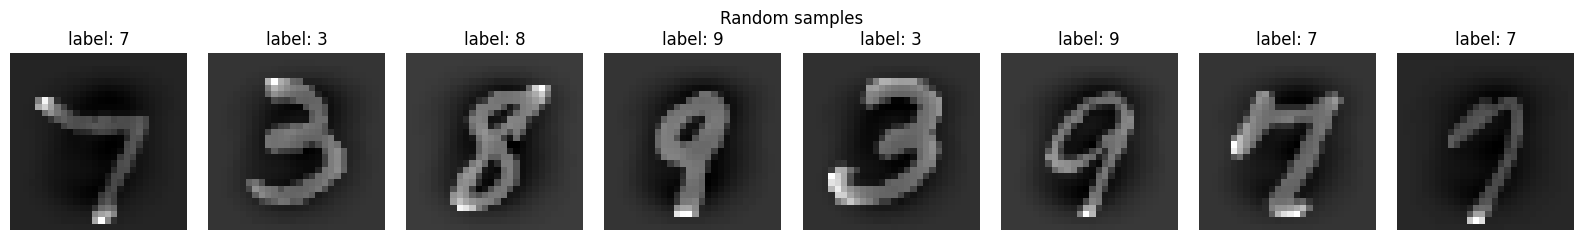

In [ ]:
# Load the mnist dataset
X_train, X_test, y_train, y_test, target_names = load_mnist_dataset()
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Number of classes: {len(target_names)}")

# 显示随机样本图像
n_show = 8
rng = np.random.RandomState(42)
idx = rng.choice(len(X_train), size=n_show, replace=False)

# 尝试推断方形尺寸
n_features = X_train.shape[1]
side = int(round(sqrt(n_features)))
is_square = (side * side == n_features)

fig, axes = plt.subplots(1, n_show, figsize=(2.0 * n_show, 2.4))
for ax, i in zip(axes, idx):
    ax.set_axis_off()
    if is_square:
        img = X_train[i].reshape(side, side)
        ax.imshow(img, cmap='gray')
        ax.set_title(f"label: {y_train[i]}")
    else:
        ax.text(0.5, 0.5, "非图像特征，无法还原为方形", ha='center', va='center')
plt.suptitle("Random samples")
plt.tight_layout()
plt.show()

## Model Definition (Default Only)

仅定义一个模型实例，使用库默认参数。

In [71]:
# Define default model with library defaults
from sklearn.linear_model import LogisticRegression
default_model = LogisticRegression(
    solver='lbfgs',
    multi_class='multinomial',
    max_iter=2000,
    random_state=RANDOM_STATE
)

## Training (Default Model)

对默认参数模型执行训练，记录训练用时。

In [72]:
# Train the default model
start_time = time.time()
default_model.fit(X_train, y_train)
default_training_time = time.time() - start_time
print(f"Default model training time: {default_training_time:.4f} seconds")

c:\Users\WHY\Projects\Personal\DL4CV\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Default model training time: 12.7900 seconds


## Evaluation (Default Model)

评估默认模型性能。

In [73]:
# Evaluate the default model
default_metrics = eval_classification(default_model, X_test, y_test, target_names)

# Enhanced evaluation with ROC-AUC for default model
enhanced_metrics = eval_classification_with_roc(
    default_model, X_test, y_test, target_names, print_report=True
)

# 显示 ROC-AUC 分数
if 'roc_auc_macro_ovr' in enhanced_metrics:
    print(f"ROC-AUC (Macro OvR): {enhanced_metrics['roc_auc_macro_ovr']:.4f}")

== Evaluation Metrics ==
accuracy                 : 0.9219
precision_macro          : 0.9210
recall_macro             : 0.9208
f1_macro                 : 0.9208
weighted_f1              : 0.9218
roc_auc_macro_ovr        : 0.9915

== Classification Report ==
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.92      0.89      0.90      1032
           3       0.90      0.91      0.91      1010
           4       0.94      0.93      0.93       982
           5       0.89      0.87      0.88       892
           6       0.94      0.95      0.95       958
           7       0.93      0.92      0.92      1028
           8       0.87      0.88      0.88       974
           9       0.91      0.92      0.91      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92     

## Visualization (Default Model)

可视化默认模型结果。

Default model confusion matrix saved to ../results/figures/part1_logistic_regression__cm_default.png


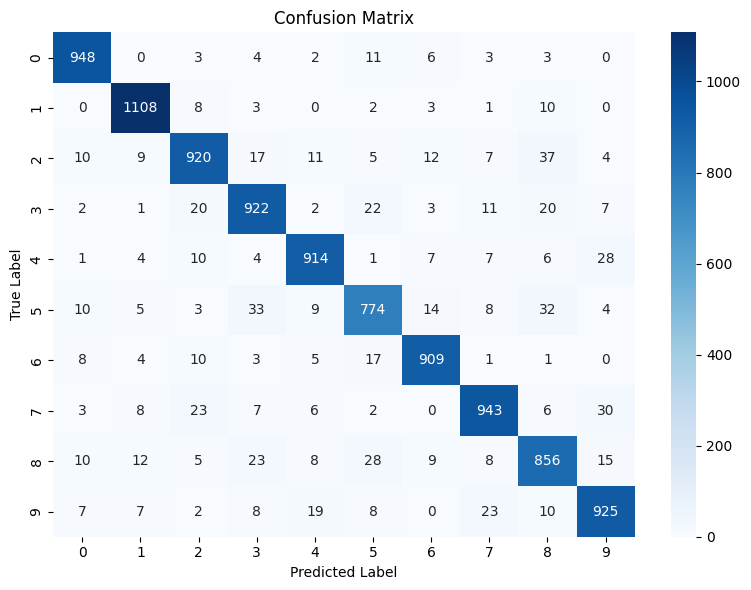

In [74]:
# 绘制混淆矩阵
cm = default_metrics['confusion_matrix']
out_png_path = f"../results/figures/{NOTEBOOK_BASENAME}__cm_default.png"

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names,
    ax=ax
)
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.tight_layout()
fig.savefig(out_png_path)
print(f"Default model confusion matrix saved to {out_png_path}")
plt.show()

## Fill Hyperparams (Tuning Spec)

定义调参网格。

In [75]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import numpy as np

# 基础模型（可替换为你当前的模型类/实例）
base_model = LogisticRegression(max_iter=1000, random_state=42)

# 多维参数网格（根据当前模型常见参数设置）
param_grid = [
    {
        "C": [0.01, 0.1, 1.0, 10.0],  # 减少 C 的范围
    },
]


# 评分可换成更合适的（如宏平均 F1）："f1_macro"
gs = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

gs.fit(X_train, y_train)
print("Best params:", gs.best_params_)
print("Best CV score (accuracy):", gs.best_score_)

# 用最佳参数在训练集上重训，并在测试集评估
best_model = gs.best_estimator_.fit(X_train, y_train)
test_acc = best_model.score(X_test, y_test)
print("Test accuracy with best params:", test_acc)

# 将 best_model 作为后续可视化/评估的当前模型
model = best_model
best_params = gs.best_params_
best_training_time = gs.cv_results_['mean_fit_time'][gs.best_index_]

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best params: {'C': 0.01}
Best CV score (accuracy): 0.92225
Test accuracy with best params: 0.9261


## Training (Tuned Model)

使用最佳参数实例化第二个模型对象并训练，记录用时。

In [76]:
# Train the best model (already done during grid search)
print(f"Best model trained with hyperparameters: {best_params}")
print(f"Training time: {best_training_time:.4f} seconds")

Best model trained with hyperparameters: {'C': 0.01}
Training time: 36.6041 seconds


## Evaluation (Tuned Model)

评估调参后模型性能。

In [77]:
# Evaluate the best model
final_metrics = eval_classification(best_model, X_test, y_test, target_names)

# Enhanced evaluation with ROC-AUC for best model
enhanced_metrics = eval_classification_with_roc(
    best_model, X_test, y_test, target_names, print_report=True
)

# 显示 ROC-AUC 分数
if 'roc_auc_macro_ovr' in enhanced_metrics:
    print(f"ROC-AUC (Macro OvR): {enhanced_metrics['roc_auc_macro_ovr']:.4f}")

== Evaluation Metrics ==
accuracy                 : 0.9261
precision_macro          : 0.9252
recall_macro             : 0.9250
f1_macro                 : 0.9250
weighted_f1              : 0.9259
roc_auc_macro_ovr        : 0.9936

== Classification Report ==
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.96      0.98      0.97      1135
           2       0.94      0.90      0.92      1032
           3       0.90      0.91      0.91      1010
           4       0.93      0.94      0.94       982
           5       0.90      0.87      0.88       892
           6       0.94      0.95      0.94       958
           7       0.93      0.92      0.92      1028
           8       0.88      0.89      0.88       974
           9       0.92      0.91      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.92      0.92     10000
weighted avg       0.93      0.93     

## Visualization (Tuned Model + Param Curves)

可视化调参后模型结果和性能曲线。

Tuned model confusion matrix saved to ../results/figures/part1_logistic_regression__cm_tuned.png


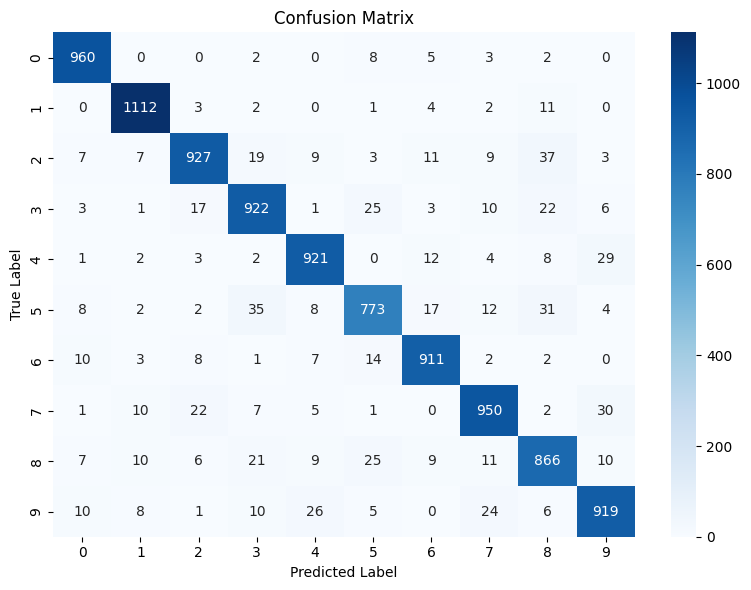

Validation curve for C saved to ../results/figures/part1_logistic_regression__acc_vs_C.png


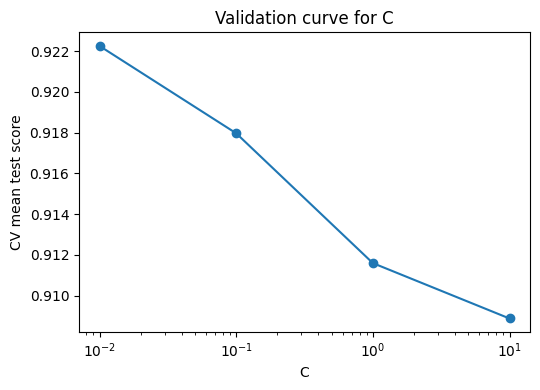

In [78]:
# 绘制混淆矩阵
cm = final_metrics['confusion_matrix']
out_png_path = f"../results/figures/{NOTEBOOK_BASENAME}__cm_tuned.png"

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names,
    ax=ax
)
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.tight_layout()
fig.savefig(out_png_path)
print(f"Tuned model confusion matrix saved to {out_png_path}")
plt.show()

# 绘制验证曲线
cv_results = gs.cv_results_
best_params = gs.best_params_
params_list = cv_results["params"]
mean_test = cv_results["mean_test_score"]

def mask_close_to_best(keys_except):
    """返回与 best_params 在除 keys_except 外的键上都匹配的布尔掩码"""
    m = np.ones(len(params_list), dtype=bool)
    for i, pr in enumerate(params_list):
        for k, v in best_params.items():
            if k in keys_except:
                continue
            if pr.get(k) != v:
                m[i] = False
                break
    return m

all_keys = sorted(best_params.keys())

for key in all_keys:
    mask = mask_close_to_best(keys_except=[key])
    idx = np.where(mask)[0]
    if len(idx) == 0:
        # 如果没有完全匹配的组合，就放宽约束，只对 key 做聚合平均
        values = defaultdict(list)
        for i, pr in enumerate(params_list):
            values[pr[key]].append(mean_test[i])
        xs = list(values.keys())
        ys = [np.mean(values[x]) for x in xs]
    else:
        xs = [params_list[i][key] for i in idx]
        ys = [mean_test[i] for i in idx]
    
    # 画图：数值型 vs 类别型分别处理
    fig, ax = plt.subplots(figsize=(5.5, 4))
    if isinstance(xs[0], (int, float, np.floating)):
        # 数值参数（例如 C）
        order = np.argsort(xs)
        xs_sorted = np.array(xs)[order]
        ys_sorted = np.array(ys)[order]
        ax.plot(xs_sorted, ys_sorted, marker='o')
        if key.lower() == 'c':
            ax.set_xscale('log')
        ax.set_xlabel(key)
        ax.set_ylabel('CV mean test score')
        ax.set_title(f'Validation curve for {key}')
    else:
        # 类别参数（例如 penalty, solver, class_weight, fit_intercept）
        uniq = list(dict.fromkeys(xs))  # 保持出现顺序
        x_idx = np.arange(len(uniq))
        # 同类名可能重复（不同组合下），对相同类别取均值
        val_map = defaultdict(list)
        for x, y in zip(xs, ys):
            val_map[x].append(y)
        y_means = [np.mean(val_map[u]) for u in uniq]
        ax.plot(x_idx, y_means, marker='o')
        ax.set_xticks(x_idx)
        ax.set_xticklabels([str(u) for u in uniq], rotation=15)
        ax.set_xlabel(key)
        ax.set_ylabel('CV mean test score')
        ax.set_title(f'Validation curve for {key}')
    
    plt.tight_layout()
    
    # 保存图表
    out_path = f"../results/figures/{NOTEBOOK_BASENAME}__acc_vs_{key}.png"
    plt.savefig(out_path)
    print(f"Validation curve for {key} saved to {out_path}")
    plt.show()

## Persist Metrics

将指标保存到指定的JSON文件。

In [79]:
# Create metrics dictionary
metrics_dict = {
    "model_name": "Logistic Regression",
    "best_hyperparams": best_params,
    "accuracy": final_metrics['accuracy'],
    "macro_f1": final_metrics['macro_f1'],
    "weighted_f1": final_metrics['weighted_f1'],
    "train_time_sec": best_training_time,
    "notes": f"Logistic Regression with C={best_params['C']} achieved {final_metrics['accuracy']:.4f} accuracy"
}

# Save metrics to JSON file
metrics_path = f"../results/metrics/{NOTEBOOK_BASENAME}__metrics.json"
with open(metrics_path, 'w', encoding='utf-8') as f:
    json.dump(metrics_dict, f, indent=2)

print(f"Metrics saved to {metrics_path}")
print(f"Final metrics: {metrics_dict}")

Metrics saved to ../results/metrics/part1_logistic_regression__metrics.json
Final metrics: {'model_name': 'Logistic Regression', 'best_hyperparams': {'C': 0.01}, 'accuracy': 0.9261, 'macro_f1': 0.9249942230968566, 'weighted_f1': 0.9259243526174156, 'train_time_sec': np.float64(36.60408067703247), 'notes': 'Logistic Regression with C=0.01 achieved 0.9261 accuracy'}


## Conclusion (Template)

使用C= \____ 的逻辑回归达到了最佳性能，准确率为 \____ 。